In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 80
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['figure.figsize'] = (10,6)
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(context="poster", style="ticks")
import ipywidgets
import yt

import glob
import os
import warnings
import h5py

import numpy as np
import pandas as pd

from units import M_solar, m_proton, pc, yr, Myr, km, s, gamma

from injection_helpers import get_SNe

from visualize_helpers import \
    get_snapshot_filenames, \
    snapshot_filename_to_number, \
    total_mass_of_snapshot, \
    total_radial_momentum_of_snapshot, \
    map_to_all_snapshots, \
    get_snapshot_times, \
    total_kinetic_energy_of_snapshot, \
    total_internal_energy_of_snapshot, \
    load_snapshots, \
    plot_projected_density, \
    plot_sliced_field, \
    plot_phase_diagram, \
    field_type, \
    plot_profile, \
    yt_plot_saver, \
    mpl_plot_saver, \
    load_ds_from_ts

import MHD
    
from sql_helpers import add_simulation, \
    open_as_DataFrame

%load_ext autoreload
%autoreload 2

`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 1.0 M_solar
    length : 1.0 pc
    time   : 1.0 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'
`grackle_helpers.wrapped_initializer` is setting up grackle assuming code units:
    mass   : 8.41e-58 M_solar
    length : 3.24e-19 pc
    time   : 3.17e-14 Myr

grackle cooling file:  b'/pfs/home/egentry/local/grackle/input/CloudyData_UVB=HM2012.h5'


In [2]:
# run_name = "cluster"
# run_name = "cluster_cooling"
# run_name = "cluster_cooling_100"
# run_name = "cluster_cooling_150"
# run_name = "cluster_cooling_200"
# run_name = "cluster_cooling_mhd_200"
# run_name = "cluster_cooling_mhd_small_200"
run_name = "cluster_cooling_mhd_large_200"
# run_name = "cluster_cooling_250"
# run_name = "cluster_cooling_300"
# run_name = "cluster_cooling_400"
# run_name = "cluster_cooling_small_300"
# run_name = "cluster_cooling_600"
# run_name = "single"
# run_name = "single_cooling"
# run_name = "double"
# run_name = "double_cooling"

run_dir = os.path.join(os.path.pardir, "runs", run_name)

inputs_dir  = os.path.join(run_dir, "inputs")
outputs_dir = os.path.join(run_dir, "outputs")

plots_dir = os.path.join(outputs_dir, "plots")
if not os.path.exists(plots_dir):
    print("making plots_dir")
    os.mkdir(plots_dir)

In [3]:
run_names = [
    "cluster_cooling_100",
    "cluster_cooling_200",
    "cluster_cooling_400",
    "cluster_cooling_mhd_large_200"
]

In [4]:
dfs = [None]*len(run_names)
for i, run_name in enumerate(run_names):
    add_simulation(run_name, verbose=False)

    df = open_as_DataFrame(run_name)
    
    dfs[i] = df

In [7]:
dfs[0].head(15)

,number,time,e_kin,e_int,e_mag,mass,momentum,run_name
0,0,0.000000,0.000000e+00,4.938177e+50,0.0,7.097382e+06,0.000000e+00,cluster_cooling_100
1,1,0.001000,0.000000e+00,1.493504e+51,0.0,7.097388e+06,0.000000e+00,cluster_cooling_100
2,2,0.127017,1.325320e+50,7.424824e+50,0.0,7.097388e+06,4.048907e+43,cluster_cooling_100
3,3,0.253034,8.578443e+49,6.853737e+50,0.0,7.097388e+06,4.463213e+43,cluster_cooling_100
4,4,0.379051,6.696951e+49,6.545448e+50,0.0,7.097388e+06,4.669316e+43,cluster_cooling_100
5,5,0.505068,5.706818e+49,6.348152e+50,0.0,7.097388e+06,4.780442e+43,cluster_cooling_100
6,6,0.631085,5.019734e+49,6.257044e+50,0.0,7.097388e+06,4.865188e+43,cluster_cooling_100
7,7,0.633085,5.019734e+49,1.625390e+51,0.0,7.097403e+06,4.865188e+43,cluster_cooling_100
8,8,1.014899,9.763975e+49,8.076482e+50,0.0,7.097403e+06,7.875604e+43,cluster_cooling_100
9,9,1.396712,7.289279e+49,6.676275e+50,0.0,7.097403e+06,8.572446e+43,cluster_cooling_100


In [5]:
SNe = get_SNe(inputs_dir)
SN_times           = np.array([SN.time          for SN in SNe])
SN_ejecta_masses   = np.array([SN.ejecta_mass   for SN in SNe])
SN_ejecta_masses_Z = np.array([SN.ejecta_mass_Z for SN in SNe])

In [6]:
dfs_energy = [None]*len(dfs)

for i, run_name in enumerate(run_names):
    outputs_dir = "../runs/{}/outputs".format(run_name)
    energies = np.loadtxt(os.path.join(outputs_dir, "energy.txt"), ndmin=2)
    
    times_statistics    = energies[:,0] * Myr
    thermal_energies    = energies[:,1] * M_solar * (pc/Myr)**2
    potential_energies  = energies[:,2] * M_solar * (pc/Myr)**2
    kinetic_energies    = energies[:,3] * M_solar * (pc/Myr)**2

    times_statistics    = times_statistics / Myr
    thermal_energies    = thermal_energies
    potential_energies  = potential_energies
    kinetic_energies    = kinetic_energies
    
    df_energy_tmp = pd.DataFrame(data={
        "time"  : times_statistics,
        "E_int" : thermal_energies,
        "E_kin" : kinetic_energies,
        "E_tot" : thermal_energies + kinetic_energies,
        
    })
    
    df_energy_tmp = df_energy_tmp[["time", "E_int", "E_kin", "E_tot"]]

    
    dfs_energy[i] = df_energy_tmp


In [16]:
dfs_energy[0].head()

,time,E_int,E_kin,E_tot
0,0.000000,4.938177e+50,0.000000e+00,4.938177e+50
1,0.001000,1.493504e+51,0.000000e+00,1.493504e+51
2,0.001000,1.493505e+51,0.000000e+00,1.493505e+51
3,0.011153,1.244959e+51,2.218132e+50,1.466773e+51
4,0.021306,1.130093e+51,2.245737e+50,1.354666e+51


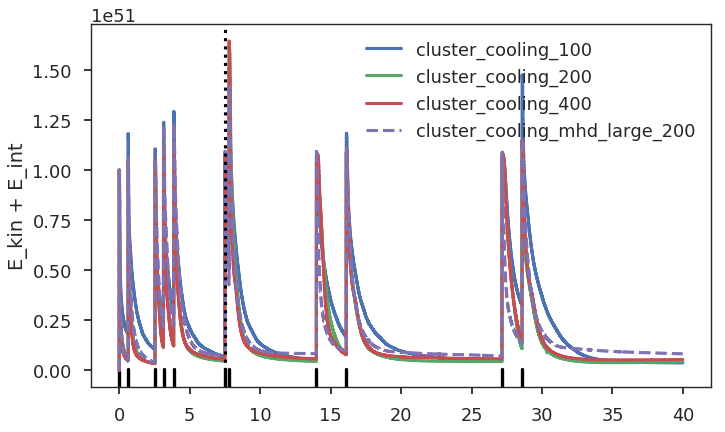

In [17]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]

    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_tot , label=run_names[i],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(-6.0043985675265733e+49, 1.6e+51)

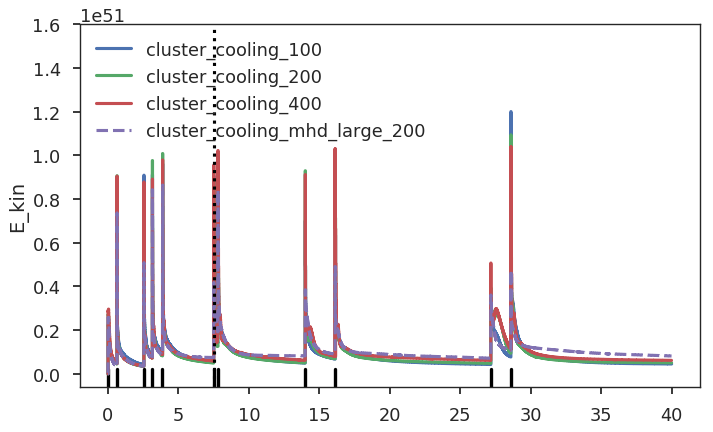

In [18]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_kin = df_energy.E_kin - df_energy.E_kin[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"
    
    plt.plot(df_energy.time, E_kin , label=run_names[i],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.ylabel("E_kin")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.ylim(top=1.6e51)

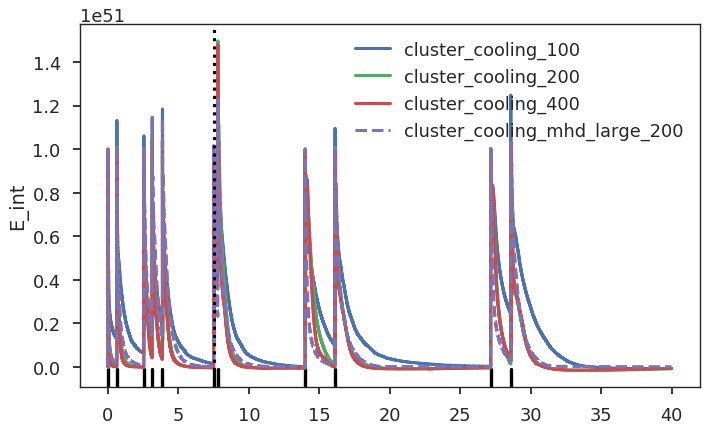

In [19]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_int = df_energy.E_int - df_energy.E_int[0]
    
    linestyle="solid"
    if "mhd" in run_names[i].lower():
        linestyle="dashed"    
    
    plt.plot(df_energy.time, E_int , label=run_names[i],
             drawstyle="steps-mid", linestyle=linestyle)
    
plt.ylabel("E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
# plt.xlim(10,15)

(2.5, 2.66)

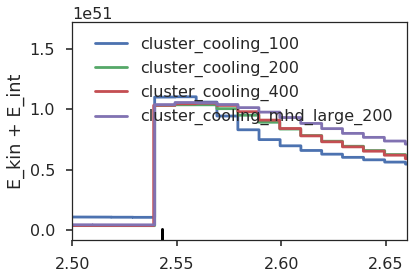

In [8]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=run_names[i],
             drawstyle="steps-mid")
    
plt.ylabel("E_kin + E_int")

plt.axvline(2.663841, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(2.5, 2.66)

(7.45, 7.6)

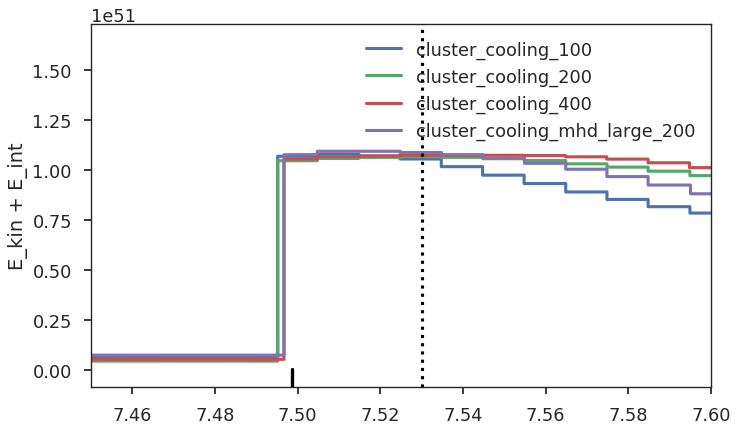

In [11]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=run_names[i],
             drawstyle="steps-mid")
    
plt.ylabel("E_kin + E_int")

plt.axvline(7.53, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(7.45,7.6)

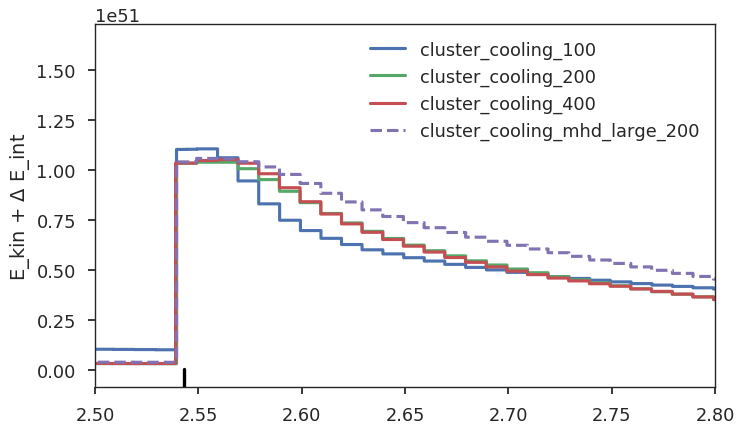

In [27]:
sns.rugplot(SN_times, color="k", linewidth=3)

for i, df_energy in enumerate(dfs_energy):
    E_tot = df_energy.E_tot - df_energy.E_tot[0]
    
    plt.plot(df_energy.time, E_tot , label=run_names[i],
             drawstyle="steps-mid")
    
df = dfs[-1]
plt.plot(df.time, df.e_mag - df.e_mag.loc[0],
         drawstyle="steps-mid", label = "$\Delta$ e_mag (3D_20_MHD)")
    
plt.ylabel("E_kin + E_int")

plt.axvline(2.663841, linestyle="dotted", color="black")
plt.legend(loc="best")
    
plt.xlim(2.5,2.8)

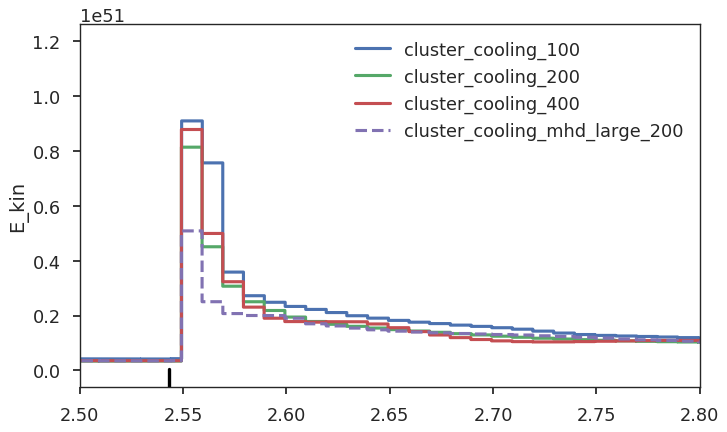

In [28]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_kin = df_energy.E_kin - df_energy.E_kin[0]

        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_kin, label=run_names[i],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("E_kin")

#     plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase diagram in paper")
    plt.legend(loc="best")

    plt.xlim(2.5, 2.8)

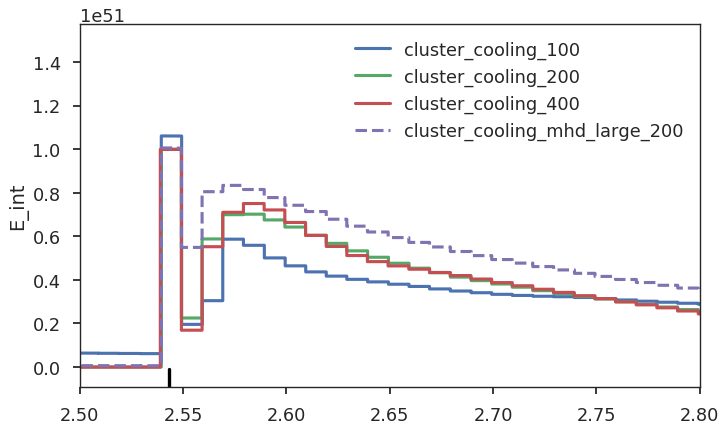

In [29]:
with sns.axes_style("ticks"):

    sns.rugplot(SN_times, color="k", linewidth=3)

    for i, df_energy in enumerate(dfs_energy):
        E_int = df_energy.E_int - df_energy.E_int[0]

        linestyle="solid"
        if "mhd" in run_names[i].lower():
            linestyle="dashed"

        plt.plot(df_energy.time, E_int, label=run_names[i],
                 drawstyle="steps-mid", linestyle=linestyle)

    plt.ylabel("E_int")

#     plt.axvline(7.53, linestyle="dotted", color="black", label="time of phase diagram in paper")
    plt.legend(loc="best")

    plt.xlim(2.5, 2.8)